In [14]:
import numpy as np
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
from simulate_data import simulate_data

# 初始化参数
lambda_val = 299792458 / 6.5e9  # 波长
dAntenna = 0.0204  # 天线间距
eps = np.finfo(float).eps
DeltaThetaDeg = [0, 90, 180,270]
# DeltaThetaDeg = [0, 120]

kAntennaPairCount = len(DeltaThetaDeg)

Nab = np.zeros((2, kAntennaPairCount))  # 天线向量
Nab[0, 0] = 0
Nab[1, 0] = dAntenna

kAntennaCount = Nab.shape[1]


for col in range(1, kAntennaPairCount):
    theta = DeltaThetaDeg[col] / 180 * np.pi
    Nab[:, col] = np.dot(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], Nab[:, 0]
    )

print(Nab)
print(Nab.shape[1])
print(kAntennaCount)
print(Nab[:,0])

[[ 0.00000000e+00 -2.04000000e-02 -2.49827947e-18  2.04000000e-02]
 [ 2.04000000e-02  1.24913974e-18 -2.04000000e-02 -3.74741921e-18]]
4
4
[0.     0.0204]


In [15]:


# 计算向量和等于零的组合
"zero antenna group"
Index = range(kAntennaPairCount)

for count in range(3, kAntennaPairCount):
    Choose = np.array(list(combinations(Index, count)))

    for row in range(len(Choose)):
        NabSum = np.array([0, 0])

        for col in range(len(Choose[row])):
            NabSum = NabSum + Nab[:, Choose[row][col] - 1]

        if np.all(np.abs(NabSum) < eps):
            chosen_row = Choose[row, :]

In [ ]:
import pandas as pd
import json

def load_real_data(file_path):
    # 方法1：手动处理JSON列（100%兼容您的格式）
    with open(file_path, 'r') as f:
        # 读取所有行
        lines = f.readlines()
        
        # 处理表头
        header = lines[0].strip().split(',')
        
        # 处理数据行
        data = []
        for line in lines[1:]:
            # 分割前4个常规字段
            parts = line.strip().split(',', 4)  # 最多分割4次
            if len(parts) == 5:
                # 解析JSON（兼容单/双引号）
                phase_diff = json.loads(parts[4].replace("'", '"'))
                data.append([
                    parts[0],       # timestamp
                    float(parts[1]), # distance(m)
                    float(parts[2]), # azimuth(deg)
                    float(parts[3]), # elevation(deg)
                    phase_diff      # phase_diff (已解析为dict)
                ])
    
    # 转换为DataFrame
    df = pd.DataFrame(data, columns=header)
    
    # 获取所有可能的相位差键（如["1-0", "2-1", "3-2", "0-3"]）
    all_keys = set()
    for x in df['phase_diff']:
        all_keys.update(x.keys())
    all_keys = sorted(all_keys)  # 固定顺序
    
    # 将字典转换为固定长度的数组
    phase_diff_array = np.zeros((len(all_keys), len(df)))
    for i, x in enumerate(df['phase_diff']):
        for j, key in enumerate(all_keys):
            phase_diff_array[j, i] = x.get(key, 0.0)  # 不存在则填0
    
    return (pd.to_datetime(df['timestamp']).values,
            df['distance(m)'].values,
            df['azimuth(deg)'].values,
            df['elevation(deg)'].values,
            phase_diff_array)

def prepare_real_data(file_path, AnchorPos):
    # 加载数据
    timestamps, distances, azimuths, elevations, phase_diffs = load_real_data(file_path)
    
    # 计算真实轨迹（极坐标→笛卡尔坐标）
    TrackTruth = np.zeros((3, len(distances)))
    TrackTruth[0, :] = distances * np.cos(np.deg2rad(elevations)) * np.cos(np.deg2rad(azimuths)) + AnchorPos[0]
    TrackTruth[1, :] = distances * np.cos(np.deg2rad(elevations)) * np.sin(np.deg2rad(azimuths)) + AnchorPos[1]
    TrackTruth[2, :] = distances * np.sin(np.deg2rad(elevations)) + AnchorPos[2]
    
    # 相位差矩阵 (N_samples × N_antenna_pairs)
    PhiDiff = phase_diffs.T  # 转置为(kAntennaCount, kSampleCount)
    
    return len(distances), TrackTruth, PhiDiff, distances

(3, 268)
(4, 268)
(268,)


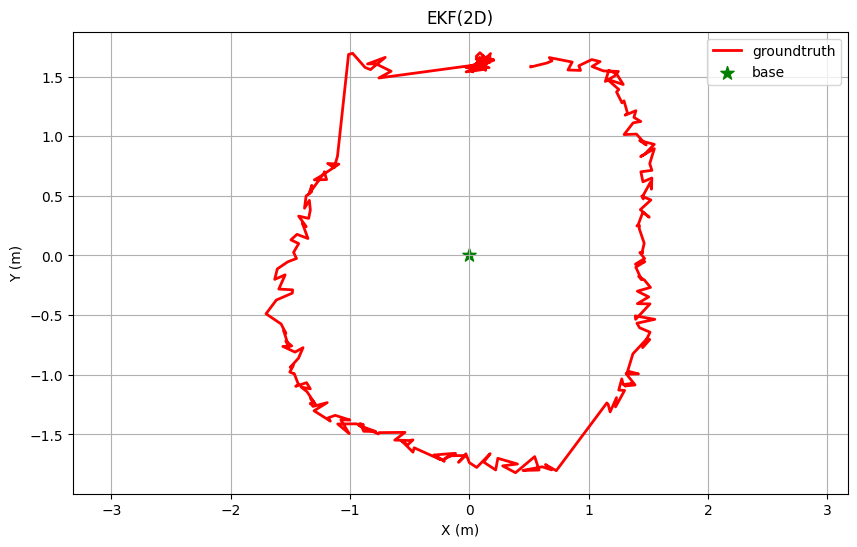

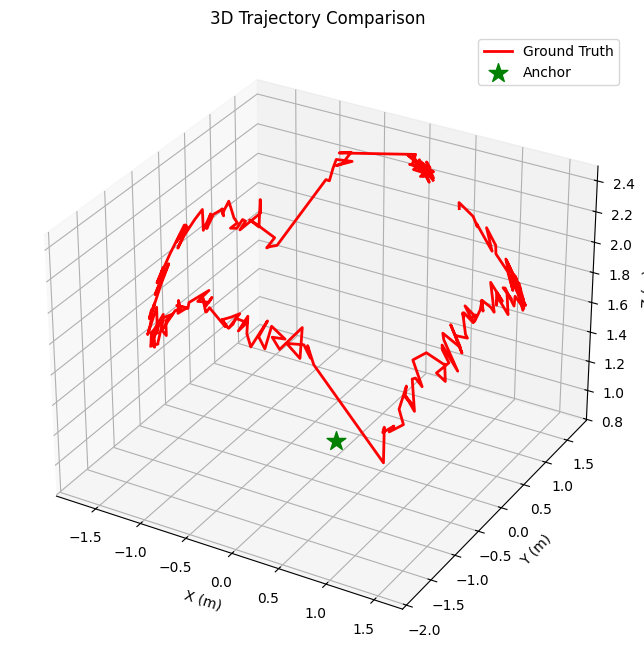

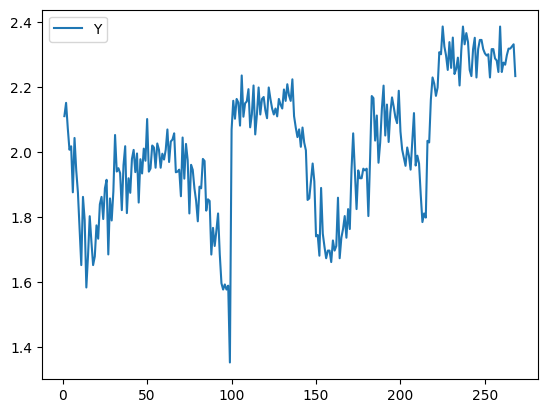

In [29]:
disStd = 0.019 * 1.0
phiStd = np.array([12.87, 4.43, 13.79, 6.23]) * np.pi / 180  # 四个天线对的噪声 [rad]



anchorZ = 0.9
AnchorPos = np.array([0, 0, anchorZ])  #基站坐标

dataSource = 1



match dataSource:
    case 0:  # 采用仿真数据
        tagZ = 0.9
        tagHeightRange = 0  # 标签在指定平面上下活动的范围
# ######   标量       标签真实轨迹   真实方位角俯仰角     相位差测量值（含噪声）   距离测量值（含噪声）
        kSampleCount, TrackTruth,    PhiThetaTruth  ,       PhiDiff,              Dis = simulate_data(
            Nab, lambda_val, AnchorPos, tagZ, disStd, phiStd
        )
    case 1:
        kSampleCount, TrackTruth, PhiDiff, Dis = prepare_real_data("uwb_data_circle.csv", AnchorPos)
    case _:
        print("dataSource is invalid! Check and retry.")

PhiDiff_deg = PhiDiff.T
PhiDiff = PhiDiff_deg * np.pi / 180
# print(kSampleCount)
# print(TrackTruth.shape)
# print(PhiDiff)
# print(PhiDiff_deg )
# print(Dis.shape)


##########异常值处理#####################

def remove_abnormal_points(data, abnormal_indices):
    """从数据中删除指定索引的点（兼容一维和二维数组）"""
    abnormal_indices = np.unique(np.sort(abnormal_indices))
    
    # 生成正常点掩码 (True=保留, False=剔除)
    mask = np.ones(data.shape[-1], dtype=bool)  # 取最后一维的长度
    mask[abnormal_indices] = False
    
    # 根据维度选择切片方式
    if data.ndim == 1:
        return data[mask]
    elif data.ndim == 2:
        return data[:, mask]
    else:
        raise ValueError("只支持一维或二维数组！")

for i in range(15):
        # 计算相邻点位移量（阈值设为0.5米）
        delta_pos = np.linalg.norm(TrackTruth[:, 1:] - TrackTruth[:, :-1], axis=0)
        abnormal_indices = np.where(delta_pos > 0.25)[0] + 1  # +1因为差分后索引偏移
        num = len(abnormal_indices)
        # print(num)
        # print("异常点索引:", abnormal_indices)
        TrackTruth = remove_abnormal_points(TrackTruth, abnormal_indices)
        PhiDiff = remove_abnormal_points(PhiDiff, abnormal_indices)
        Dis = remove_abnormal_points(Dis, abnormal_indices)

print(TrackTruth.shape)
print(PhiDiff.shape)
print(Dis.shape)
kSampleCount = TrackTruth.shape[1]
##########异常值处理#####################


from mpl_toolkits.mplot3d import Axes3D
def plt_truth2D():
        plt.figure(figsize=(10, 6))
        plt.plot(TrackTruth[0], TrackTruth[1], 'r-', linewidth=2, label='groundtruth')
        plt.scatter(0, 0, c='green', s=100, marker='*', label='base')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('EKF(2D)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # 保证x/y轴比例一致
def plt_truth3D():
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 绘制轨迹
        ax.plot(TrackTruth[0], TrackTruth[1], TrackTruth[2], 
                'r-', label='Ground Truth', linewidth=2)
  
        # ax.plot(TrackWithDis[0], TrackWithDis[1], TrackWithDis[2], 
        #         'g--', label='TrackWithDis', linewidth=1.5)

        # 绘制基站
        ax.scatter(AnchorPos[0], AnchorPos[1], AnchorPos[2], 
                c='green', s=200, marker='*', label='Anchor')

        # 美化设置
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('3D Trajectory Comparison')
        ax.legend()
        ax.grid(True)


plt_truth2D()
plt_truth3D()

plt.figure()
plt.plot(np.arange(1, TrackTruth.shape[1]+1), TrackTruth[2,:], label="Y")
plt.legend()


In [18]:
# TrackWithDis = np.full((3, kSampleCount), np.nan)  # PDOA+TWR
# # 转换 aoa 角度到统一坐标 0~360
# A = Nab.T
# print(  A)
# AAA = np.linalg.lstsq(A.T @ A, A.T, rcond=None)[0]

# for index in range(kSampleCount):
#     r = Dis[index]
#     DeltaR = PhiDiff[:, index] * lambda_val / (2 * np.pi)

#     print(r.shape)
#     print(DeltaR.shape)
#     B = A[:, 0] * AnchorPos[0] + A[:, 1] * AnchorPos[1] - r * DeltaR
#     X = AAA @ B
#     # FIXME 这里只是为了临时屏蔽大角度边缘区域高度计算虚数问题
#     z = AnchorPos[2] + np.sqrt(
#         np.abs(r**2 - (X[0] - AnchorPos[0]) ** 2 - (X[1] - AnchorPos[1]) ** 2)
#     )
#     TrackWithDis[:, index] = np.concatenate((X, [z]))


# # plt.figure()
# # plt.plot(np.arange(1, kSampleCount + 1), Dis, label="Dis")
# # plt.legend()

# def plt3():
#         fig = plt.figure(figsize=(12, 8))
#         ax = fig.add_subplot(111, projection='3d')

#         # 绘制轨迹
#         ax.plot(TrackTruth[0], TrackTruth[1], TrackTruth[2], 
#                 'r-', label='Ground Truth', linewidth=2)
  
#         ax.plot(TrackWithDis[0], TrackWithDis[1], TrackWithDis[2], 
#                 'g--', label='TrackWithDis', linewidth=1.5)

#         # 绘制基站
#         ax.scatter(AnchorPos[0], AnchorPos[1], AnchorPos[2], 
#                 c='green', s=200, marker='*', label='Anchor')

#         # 美化设置
#         ax.set_xlabel('X (m)')
#         ax.set_ylabel('Y (m)')
#         ax.set_zlabel('Z (m)')
#         ax.set_title('3D Trajectory Comparison')
#         ax.legend()
#         ax.grid(True)

# plt3()


In [19]:
# #########################
# 加入EKF
############################


# 初始状态（假设标签从原点静止启动）
x_est = np.array([0, 0, 1.8, 0, 0, 0])  # [x, y, z, vx, vy, vz]
P_est = np.diag([0.4,0.4 , 0.04 ,0.3,0.3,0.3  ])  # 初始协方差矩1

x_forward = np.zeros((6, kSampleCount))
P_forward = np.zeros((6, 6, kSampleCount))

# 初始化EKF轨迹存储（3行：x,y,z；kSampleCount列）
TrackEKF = np.full((3, kSampleCount), np.nan)  # 初始值为NaN
TrackEKF_residu  = np.full((5, kSampleCount), np.nan)  # 初始值为NaN
TrackEKF_velocity =  np.full((3, kSampleCount), np.nan)  
P_east_history = np.full((1, kSampleCount), np.nan)  # 初始值为NaN
K_history = np.zeros((6, kAntennaCount + 1, kSampleCount))  # 存储 K

# 过程噪声
Q = np.diag([0.01, 0.01, 0.2, 0.5, 0.5, 0.3])

# 观测噪声（从仿真参数生成）
R_phi = np.diag(phiStd ** 2)  # 相位差噪声
R_dis = disStd ** 2                           # 距离噪声
R = np.block([[R_phi, np.zeros((4, 1))],
              [np.zeros((1, kAntennaCount)), R_dis]])
def observation_model(x, AnchorPos, Nab, lambda_val):

    pos = x[:3]
    r = np.linalg.norm(pos - AnchorPos)
    
    vTO = AnchorPos - pos
    vTO = (AnchorPos - pos) / r  # 单位方向向量
    PhiDiff_ekf = np.zeros(Nab.shape[1])
    for i in range(Nab.shape[1]):
        vNab = np.array([Nab[0, i], Nab[1, i], 0])  # 天线对向量
        deltaR = np.dot(vTO, vNab)
        PhiDiff_ekf[i] = (2 * np.pi / lambda_val) * deltaR
    
    # 合并观测值
    z = np.concatenate([PhiDiff_ekf, [r]])
    return z


def get_F_matrix(x_est, dt):
    """CV模型基础"""
    return np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])

def compute_H(x_pred, AnchorPos, Nab, lambda_val, eps=1e-6):
    """数值法计算雅可比矩阵（带防错处理）"""
    H = np.zeros((kAntennaCount + 1, 6))
    h0 = observation_model(x_pred, AnchorPos, Nab, lambda_val)
    
    for i in range(6):
        dx = np.zeros(6)
        dx[i] = eps
        h_eps = observation_model(x_pred + dx, AnchorPos, Nab, lambda_val)
        H[:, i] = (h_eps - h0) / eps

    return H


for index in range(kSampleCount):
    # print(f"\n=== 步骤 {index} ===")
    
    # 获取当前测量值
    z_meas = np.concatenate([PhiDiff[:, index], [Dis[index]]])
    # print(f"测量值z坐标: {TrackWithDis[2,index]}")


   
    
    if z_meas is not None:
        # --- 预测步（CT模型）---
        dt = 1.0 / kSampleCount  # 根据实际时间调整
        F = get_F_matrix(x_est, dt)
        # print(f"状态转移矩阵 F:\n{F}")
        
        x_pred = F @ x_est
        # print(f"预测状态 x_pred的z坐标: {x_pred[2]}")
        
        P_pred = F @ P_est @ F.T + Q
        # print(f"预测协方差 P_pred:\n{P_pred}")
        
        # --- 更新步 ---
        # 计算雅可比矩阵H（数值法简化实现）
        H = compute_H(x_pred, AnchorPos, Nab, lambda_val)
        # print(f"观测矩阵 H:\n{H}")
        
        # 卡尔曼增益
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        # print(f"卡尔曼增益 K:\n{K}")
        
        # 状态更新
        z_pred = observation_model(x_pred, AnchorPos, Nab, lambda_val)  #估计值
        # print(f"预测观测值 z_pred: {z_pred}")
        
        innovation = z_meas - z_pred
        # print(f"新息 (z_meas - z_pred): {innovation}")
        
        x_est = x_pred + K @ innovation
        # print(f"更新后状态 x_est: {x_est}")
        
        P_est = (np.eye(6) - K @ H) @ P_pred   #协方差更新
    

        # 存储结果
        TrackEKF[:, index] = x_est[:3]
        TrackEKF_residu[:,index] =innovation[:5] 
        TrackEKF_velocity[:,index]= x_est[3:6]
        P_east_history[:,index] = P_pred[2,2]

        K_history[:, :, index] = K 




In [20]:
# # print(TrackEKF_residu)
# # print(P_east_history)

# plt.figure()
# plt.plot(np.arange(1, kSampleCount + 1), P_east_history[0,:], label="Pz")
# plt.legend()


# plt.figure()
# plt.plot(np.arange(1, kSampleCount + 1), TrackEKF_velocity[2,:], label="Vz")
# plt.legend()

# plt.figure()
# plt.plot(np.arange(1, kSampleCount + 1), TrackEKF[2,:], label="Xz")
# plt.legend()

# plt.figure()
# plt.plot(K_history[2, -1, :], 'b-', label='K[2,-1] (z gain for distance measurement)')
# plt.xlabel('Time Step')
# plt.ylabel('Kalman Gain (z)')
# plt.legend()
# plt.title('Kalman Gain for z Position')
# plt.grid(True)


373
(3, 373)
[[ 0.          1.98697913  2.03575099 ...  1.97702022  2.02429615
   1.95144667]
 [ 0.          0.87822153  0.77555191 ...  0.1059769   0.26901878
   0.24287297]
 [ 0.         -2.42567065 -2.31799745 ... -2.25728656 -2.20406384
  -2.25696147]
 [ 0.         -0.43953002 -0.49330544 ...  0.17428944 -0.08925109
   0.06264182]]


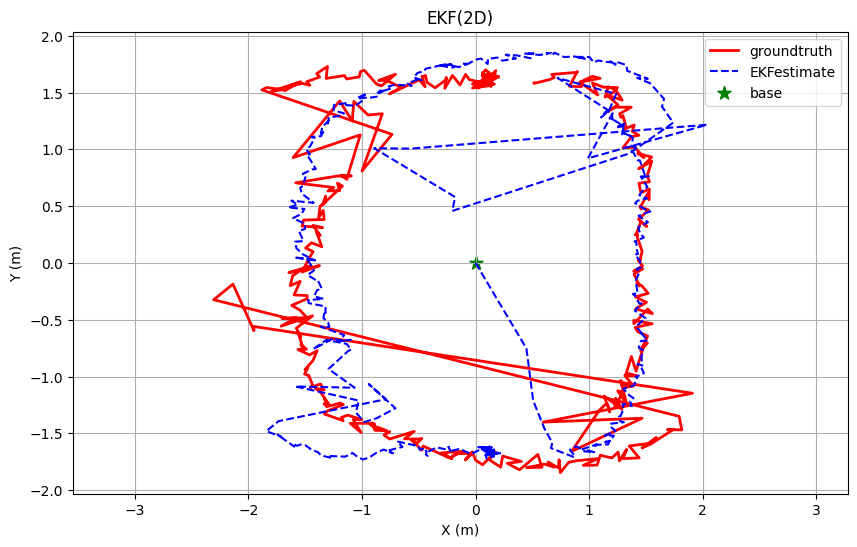

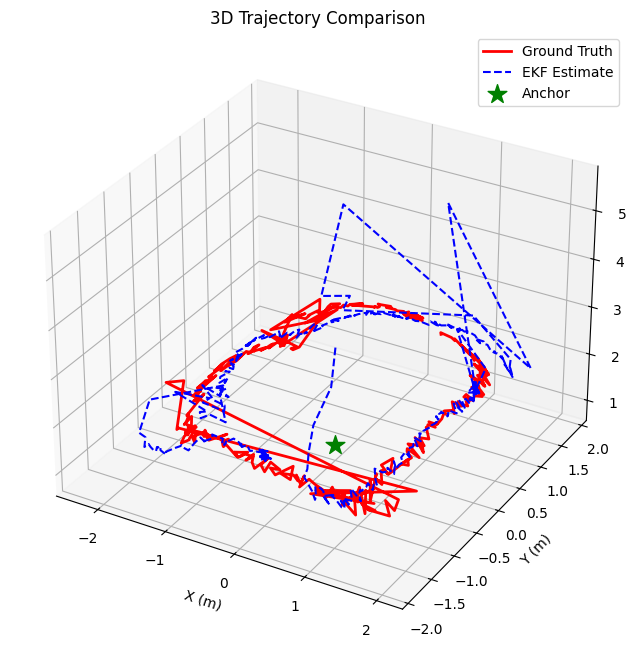

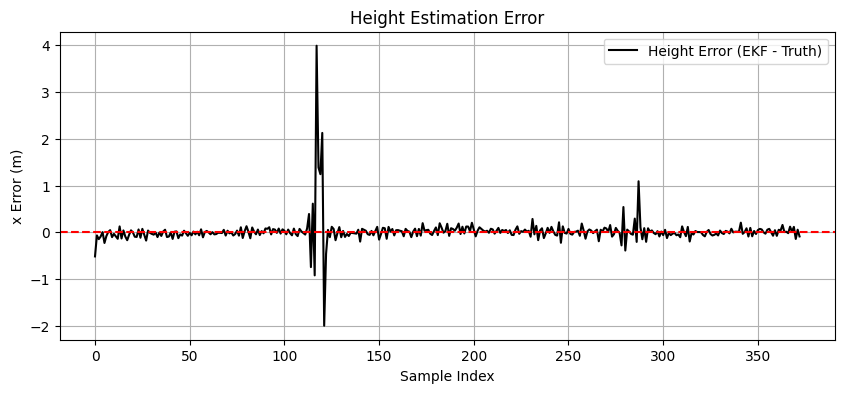

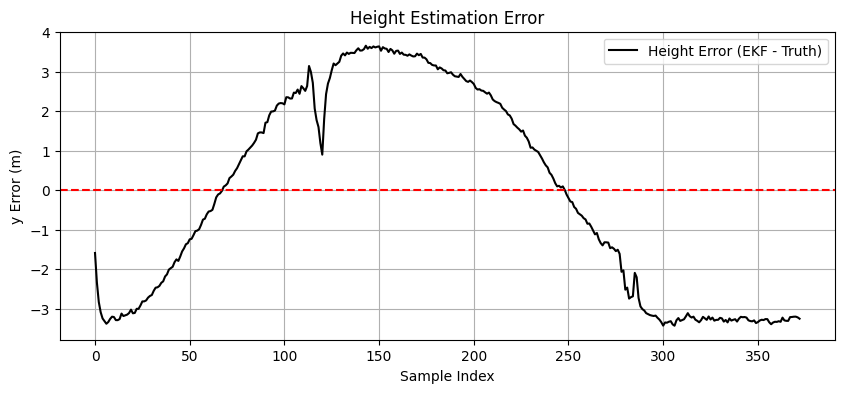

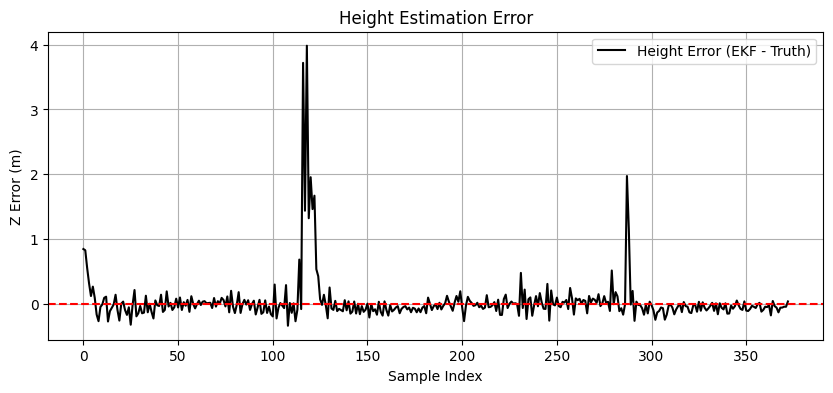

In [21]:
from mpl_toolkits.mplot3d import Axes3D
def plt1():
        plt.figure(figsize=(10, 6))
        plt.plot(TrackTruth[0], TrackTruth[1], 'r-', linewidth=2, label='groundtruth')
        plt.plot(TrackEKF[0], TrackEKF[1], 'b--', linewidth=1.5, label='EKFestimate')
        plt.scatter(AnchorPos[0], AnchorPos[1], c='green', s=100, marker='*', label='base')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('EKF(2D)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # 保证x/y轴比例一致
def plt2():
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 绘制轨迹
        ax.plot(TrackTruth[0], TrackTruth[1], TrackTruth[2], 
                'r-', label='Ground Truth', linewidth=2)
        ax.plot(TrackEKF[0], TrackEKF[1], TrackEKF[2], 
                'b--', label='EKF Estimate', linewidth=1.5)
        # ax.plot(TrackWithDis[0], TrackWithDis[1], TrackWithDis[2], 
        #         'g--', label='TrackWithDis', linewidth=1.5)

        # 绘制基站
        ax.scatter(AnchorPos[0], AnchorPos[1], AnchorPos[2], 
                c='green', s=200, marker='*', label='Anchor')

        # 美化设置
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('3D Trajectory Comparison')
        ax.legend()
        ax.grid(True)
def plt3():
        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[0] - TrackTruth[0], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('x Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)


        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[1] - TrackTruth[1], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('y Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)

        plt.figure(figsize=(10, 4))
        plt.plot(TrackEKF[2] - TrackTruth[2], 'k-', label='Height Error (EKF - Truth)')
        plt.axhline(0, color='r', linestyle='--')
        plt.xlabel('Sample Index')
        plt.ylabel('Z Error (m)')

        plt.title('Height Estimation Error')
        plt.legend()
        plt.grid(True)
plt1()
plt2()
plt3()


print(kSampleCount)
print(TrackTruth.shape)
print(PhiDiff)
# print(Dis)


In [22]:


# plt.figure()
# for index in range(PhiDiff.shape[0]):
#     plt.plot(
#         np.arange(1, kSampleCount + 1),
#         PhiDiff[index, :] * 180 / np.pi,
#         label=f"phi diff {index}",
#     )
# plt.plot(
#     np.arange(1, kSampleCount + 1),
#     np.sum(PhiDiff, axis=0) * 180 / np.pi,
#     label="phi diff sum",
# )
# plt.legend()

# 相位差的和应为0附近，三对天线对称分布

In [23]:
# plt.figure(figsize=(10, 6))

# # 绘制轨迹
# if "TrackTruth" in locals():
#     plt.plot(TrackTruth[0, :], TrackTruth[1, :], 'r-', linewidth=2, label='Ground Truth')

# plt.plot(TrackWithDis[0, :], TrackWithDis[1, :], 'b-', linewidth=1.5, label='TrackWithDis')
# # plt.plot(TrackWithoutDis[0, :], TrackWithoutDis[1, :], 
# #          'm-.', linewidth=2, alpha=0.7, label='TrackWithoutDis')
# plt.plot(TrackWithDisAndFixedHeight[0, :], TrackWithDisAndFixedHeight[1, :], 
#          'g--', linewidth=1.5, label='TrackWithDisAndFixedHeight')
# plt.plot(TrackEKF[0], TrackEKF[1], 
#          'k:', linewidth=2.5, label='EKF Estimate')

# # 绘制基站位置
# plt.scatter(AnchorPos[0], AnchorPos[1], c='orange', s=150, marker='*', label='Anchor')

# # 添加标签和样式
# plt.xlabel('X (m)', fontsize=12)
# plt.ylabel('Y (m)', fontsize=12)
# plt.title('Positioning Methods Comparison (2D)', fontsize=14)
# plt.legend(fontsize=10, loc='best')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.axis('equal')


# plt.tight_layout()  # 自动调整子图参数
# plt.show()

In [24]:
# plt.figure(figsize=(12, 8))

# # 时间轴（采样点）
# t = np.arange(1, kSampleCount + 1)

# # 绘制各方法X/Y/Z分量
# if "TrackTruth" in locals():
#     plt.plot(t, TrackTruth[0, :], 'r-', linewidth=2, label='GroundTruth_x')
#     plt.plot(t, TrackTruth[1, :], 'r--', linewidth=2, label='GroundTruth_y')
#     plt.plot(t, TrackTruth[2, :], 'r:', linewidth=2, label='GroundTruth_z')

# plt.plot(t, TrackWithDis[0, :], 'b-', linewidth=1.5, alpha=0.7, label='TrackWithDis_x')
# plt.plot(t, TrackWithDis[1, :], 'b--', linewidth=1.5, alpha=0.7, label='TrackWithDis_y')
# plt.plot(t, TrackWithDis[2, :], 'b:', linewidth=1.5, alpha=0.7, label='TrackWithDis_z')

# # plt.plot(t, TrackWithoutDis[0, :], 'g-', linewidth=1.5, alpha=0.7, label='TrackWithoutDis_x')
# # plt.plot(t, TrackWithoutDis[1, :], 'g--', linewidth=1.5, alpha=0.7, label='TrackWithoutDis_y')
# # plt.plot(t, TrackWithoutDis[2, :], 'g:', linewidth=1.5, alpha=0.7, label='TrackWithoutDis_z')

# plt.plot(t, TrackWithDisAndFixedHeight[0, :], 
#          'm-', linewidth=1.5, alpha=0.7, label='TrackWithDisAndFixedHeight_x')
# plt.plot(t, TrackWithDisAndFixedHeight[1, :], 
#          'm--', linewidth=1.5, alpha=0.7, label='TrackWithDisAndFixedHeight_y')
# plt.plot(t, TrackWithDisAndFixedHeight[2, :], 
#          'm:', linewidth=1.5, alpha=0.7, label='TrackWithDisAndFixedHeight_z')

# # 添加EKF数据
# plt.plot(t, TrackEKF[0, :], 'k-', linewidth=2.5, label='EKF_x')
# plt.plot(t, TrackEKF[1, :], 'k--', linewidth=2.5, label='EKF_y')
# plt.plot(t, TrackEKF[2, :], 'k:', linewidth=2.5, label='EKF_z')

# # 图形美化
# plt.xlabel('Sample Index', fontsize=12)
# plt.ylabel('Position (m)', fontsize=12)
# plt.title('Position Components Comparison', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.3)

# # 智能图例处理（合并同类项）
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))  # 去重
# plt.legend(by_label.values(), by_label.keys(), 
#            bbox_to_anchor=(1.05, 1), 
#            loc='upper left', 
#            fontsize=10)

# plt.tight_layout()
# plt.show()


In [25]:
# if "TrackTruth" in locals():
#     plt.figure(figsize=(10, 6))
#     t = np.arange(1, kSampleCount + 1)
    
#     # TrackWithDis errors
#     plt.plot(t, TrackWithDis[0, :] - TrackTruth[0, :], 'b-', label='Error_x (PDOA+TWR)')
#     plt.plot(t, TrackWithDis[1, :] - TrackTruth[1, :], 'b--', label='Error_y (PDOA+TWR)')
#     plt.plot(t, TrackWithDis[2, :] - TrackTruth[2, :], 'b:', label='Error_z (PDOA+TWR)')
    
#     # # TrackWithoutDis errors
#     # plt.plot(t, TrackWithoutDis[0, :] - TrackTruth[0, :], 'g-', label='Error_x (PDOA Only)')
#     # plt.plot(t, TrackWithoutDis[1, :] - TrackTruth[1, :], 'g--', label='Error_y (PDOA Only)')
#     # plt.plot(t, TrackWithoutDis[2, :] - TrackTruth[2, :], 'g:', label='Error_z (PDOA Only)')
    
#     # TrackWithDisAndFixedHeight errors
#     # plt.plot(t, TrackWithDisAndFixedHeight[0, :] - TrackTruth[0, :], 'm-', label='Error_x (PDOA+TWR+FixedH)')
#     # plt.plot(t, TrackWithDisAndFixedHeight[1, :] - TrackTruth[1, :], 'm--', label='Error_y (PDOA+TWR+FixedH)')
#     # plt.plot(t, TrackWithDisAndFixedHeight[2, :] - TrackTruth[2, :], 'm:', label='Error_z (PDOA+TWR+FixedH)')
    
#     # EKF errors
#     plt.plot(t, TrackEKF[0, :] - TrackTruth[0, :], 'k-', linewidth=2, label='Error_x (EKF)')
#     plt.plot(t, TrackEKF[1, :] - TrackTruth[1, :], 'k--', linewidth=2, label='Error_y (EKF)')
#     plt.plot(t, TrackEKF[2, :] - TrackTruth[2, :], 'k:', linewidth=2, label='Error_z (EKF)')
    
#     plt.xlabel('Sample Index')
#     plt.ylabel('Position Error (m)')
#     plt.title('Positioning Error Comparison')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True, linestyle='--', alpha=0.5)
#     plt.tight_layout()
#     plt.show()

In [26]:


# plt.figure()
# plt.plot(range(1, kSampleCount + 1), PhiTheta[0, :] * 180 / np.pi, label="Phi")
# plt.plot(range(1, kSampleCount + 1), PhiTheta[1, :] * 180 / np.pi, label="Theta")
# if "PhiThetaTruth" in locals():
#     plt.plot(
#         range(1, kSampleCount + 1), PhiThetaTruth[0, :] * 180 / np.pi, label="PhiTruth"
#     )
#     plt.plot(
#         range(1, kSampleCount + 1),
#         PhiThetaTruth[1, :] * 180 / np.pi,
#         label="ThetaTruth",
#     )
# plt.legend()

# plt.show()


